<a href="https://colab.research.google.com/github/LinusBach/SentimentAnalysis/blob/main/sentiAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple sentiment analysis

Sentiment analysis, using iMDB database

First, implement and train a feedforward NN model with TF-IDF. And then train your
model using word2vec embedding. Report both training and development accuracy on
the dataset. Try to use stochastic gradient descent or (mini-batch) stochastic gradient
descent!

requires word2vec model https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

In [1]:
!pip install tensorflow
!pip install nltk
!pip install gensim
!pip install matplotlib

### imports


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
import nltk
import csv
import numpy as np
import gensim
import matplotlib.pyplot as plt

# number of words to include
VOCAB_SIZE = 5000
# number of most frequent words to be disregarded
HIGHER_CUTOFF = 0

2023-05-12 11:25:42.890084: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-12 11:25:42.969732: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-12 11:25:42.970518: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 11:25:44.117921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### load dataset into memory
return a list of docs and a list of respective labels

In [3]:
def load_data (filename):
  content = list()
  labels = list()
  with open(filename, 'r') as file:
    reader = csv.reader(file)
    # skip header 
    next(reader)
    for c, l in reader:
      content.append(c)
      labels.append(l)
  return content, labels

### turn a dataset into clean tokens

In [4]:
def clean_data(data):
  corpus = list()
  corp_voc = dict()
  stop = nltk.corpus.stopwords.words("english")
  # regex tokenizer, find words, numbers and words containing '
  tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+(?:'\w)?")
  for doc in data:
    doc = tokenizer.tokenize(doc)
    doc_cleaned = dict()
    for tok in doc:
      # make all words lower case
      tok = tok.lower()
      # filter out numbers 
      if not tok.isdigit() and tok not in stop:
        # add clean token to document
        if tok in doc_cleaned:
          doc_cleaned[tok] += 1
        else:
          doc_cleaned[tok] = 1
    for tok in doc_cleaned.keys():
    # increase corpus vocabulary
        if tok in corp_voc:
          corp_voc[tok] += 1
        else:
          corp_voc[tok] = 1
    corpus.append(doc_cleaned)
  return corpus, corp_voc

# filter all words out of a corpus that are not in a vocabulary
def get_filtered_corpus(corpus, vocab):
  clean_corpus = list()
  for doc in corpus:
    clean_doc = dict()
    for tok in doc:
      if tok in vocab:
        clean_doc[tok] = doc[tok]
    clean_corpus.append(clean_doc)
  return clean_corpus

### preprocess the dataset

tf-idf vectorizer

In [5]:

# corpus must be a list of dicts of form (token: occurences)
# vocab must be a dict of form (token: documents in corpus containing token)
def preprocess_tf_idf(corpus, vocab):
  processed = np.zeros((len(corpus), len(vocab)))
  idf = get_idf(vocab)
  token_order = {tok: i for i, tok, in enumerate(sorted(vocab.keys()))}
  for n_doc, doc in enumerate(corpus):
    tf = get_tf(doc)
    for tok in set(doc):
      tok_pos = token_order[tok]
      processed[n_doc][tok_pos] = tf[tok]*idf[tok]
  return processed

def get_tf(doc):
  tf = dict()
  for tok, occ in doc.items():
    tf[tok] = occ / len(doc)
  return tf

def get_idf(corp_voc):
  idf = dict()
  for tok, docs_containing in corp_voc.items():
    idf[tok] = np.log10(len(corp_voc) / docs_containing)
  return idf


semantic embeddings
pooling word2vec embeddings

In [6]:
def preprocess_sem_vec(corpus, vocab_vectors):
  processed = list()
  for n_doc, doc in enumerate(corpus):
    vecs = [occ*vocab_vectors[tok] for tok, occ in doc.items() if tok in vocab_vectors]
    processed.append(np.mean(vecs, axis=0))
  return np.array(processed)

### define the model


In [7]:
def define_model(input_dim):
  model = keras.models.Sequential()
  model.add(layers.Dense(127, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(63, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))
  return model

plotting trainig history

In [8]:
def plot_training(history):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(1, len(train_loss) + 1)
  
  # Plot the training and validation loss
  plt.plot(epochs, train_loss, 'b-', label='Training Loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  
  # Plot the training and validation accuracy
  plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

### classify a review as negative or positive.

In [9]:
def predict_sentiment(model, doc):
  return model.predict(doc)

## Running the model

Setting constants

In [10]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
EPOCHS = 20

load training data

In [11]:
# read data from file
raw_data, labels = load_data("Train.csv")
full_corpus, full_vocab = clean_data(raw_data)
# select part of vocabulary
frequencies = sorted(full_vocab.items(), key=lambda x : x[1], reverse=True)
vocab = {x[0] : x[1] for x in frequencies[HIGHER_CUTOFF:HIGHER_CUTOFF+VOCAB_SIZE]}
corpus = get_filtered_corpus(full_corpus, vocab.keys())
# process labels
one_hot_labels = keras.utils.to_categorical(labels)

load validation data

In [12]:
v_raw, v_labels = load_data("Valid.csv")
full_valid_corpus, _ = clean_data(v_raw)
valid_corpus = get_filtered_corpus(full_valid_corpus, vocab)
valid_labels = keras.utils.to_categorical(v_labels)

load testing data

In [13]:
t_raw, t_labels = load_data("Test.csv")
full_test_corpus, _ = clean_data(t_raw)
test_corpus = get_filtered_corpus(full_test_corpus, vocab)
test_labels = keras.utils.to_categorical(t_labels)

### train a model on tf-idf data 

In [14]:
# get tf-idf representation of data
tfidf_data = preprocess_tf_idf(corpus, vocab)
test_data = preprocess_tf_idf(test_corpus, vocab)
valid_data = preprocess_tf_idf(valid_corpus, vocab)

begin training
Epoch 1/20
313/313 [==============================] - 2s 5ms/step - loss: 0.6913 - accuracy: 0.6112 - val_loss: 0.6856 - val_accuracy: 0.7740
Epoch 2/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6626 - accuracy: 0.7783 - val_loss: 0.6207 - val_accuracy: 0.8358
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 0.5612 - accuracy: 0.8281 - val_loss: 0.4906 - val_accuracy: 0.8570
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 0.4411 - accuracy: 0.8566 - val_loss: 0.3921 - val_accuracy: 0.8686
Epoch 5/20
313/313 [==============================] - 1s 4ms/step - loss: 0.3660 - accuracy: 0.8691 - val_loss: 0.3398 - val_accuracy: 0.8722
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 0.3211 - accuracy: 0.8821 - val_loss: 0.3121 - val_accuracy: 0.8764
Epoch 7/20
313/313 [==============================] - 1s 4ms/step - loss: 0.2948 - accuracy: 0.8882 - val_loss: 0.2963 - val_accuracy

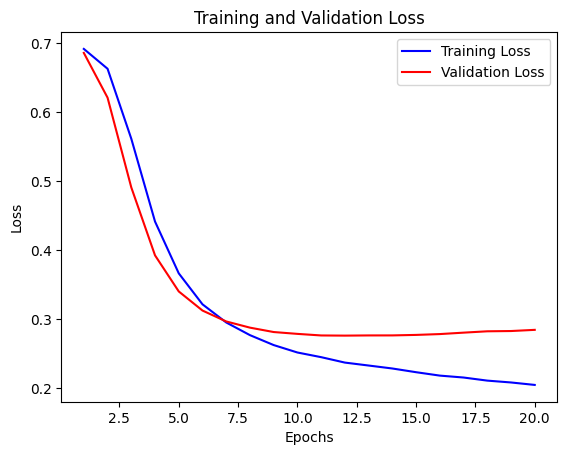

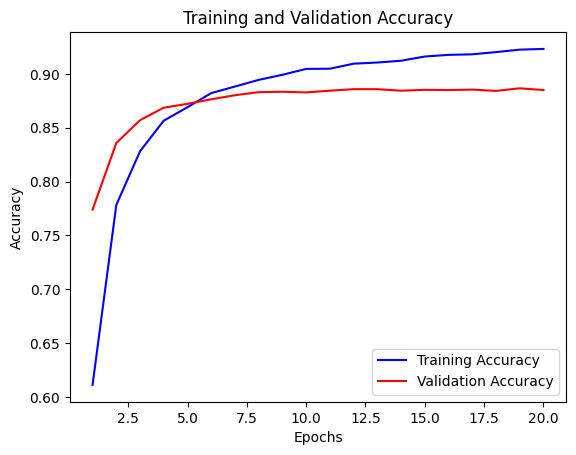

157/157 [==============================] - 0s 1ms/step - loss: 0.2824 - accuracy: 0.8874


[0.2823541462421417, 0.8873999714851379]

In [15]:
# build model
tfidf_model = define_model(VOCAB_SIZE,)
tfidf_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy'])
# train model
print("begin training")
tfidf_history = tfidf_model.fit(
    tfidf_data,
    one_hot_labels,
    validation_data=(valid_data, valid_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE)
plot_training(tfidf_history)
# evaluate model
tfidf_model.evaluate(test_data, test_labels)

### train a model on word2vec embeddings 

In [16]:
# get semantic embeddings of data
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
vocab_vecs = {tok : word2vec_model[tok] for tok in vocab.keys() if tok in word2vec_model.key_to_index}
w2v_train_data = preprocess_sem_vec(corpus, vocab_vecs)
w2v_valid_data = preprocess_sem_vec(valid_corpus, vocab_vecs)
w2v_test_data = preprocess_sem_vec(test_corpus, vocab_vecs)

begin training
Epoch 1/20
313/313 [==============================] - 2s 3ms/step - loss: 0.6774 - accuracy: 0.5980 - val_loss: 0.6297 - val_accuracy: 0.7862
Epoch 2/20
313/313 [==============================] - 1s 2ms/step - loss: 0.5757 - accuracy: 0.7469 - val_loss: 0.4797 - val_accuracy: 0.8060
Epoch 3/20
313/313 [==============================] - 1s 2ms/step - loss: 0.4753 - accuracy: 0.7937 - val_loss: 0.4155 - val_accuracy: 0.8208
Epoch 4/20
313/313 [==============================] - 1s 2ms/step - loss: 0.4340 - accuracy: 0.8105 - val_loss: 0.3906 - val_accuracy: 0.8264
Epoch 5/20
313/313 [==============================] - 1s 2ms/step - loss: 0.4127 - accuracy: 0.8216 - val_loss: 0.3767 - val_accuracy: 0.8342
Epoch 6/20
313/313 [==============================] - 1s 2ms/step - loss: 0.3996 - accuracy: 0.8270 - val_loss: 0.3661 - val_accuracy: 0.8426
Epoch 7/20
313/313 [==============================] - 1s 2ms/step - loss: 0.3903 - accuracy: 0.8327 - val_loss: 0.3594 - val_accuracy

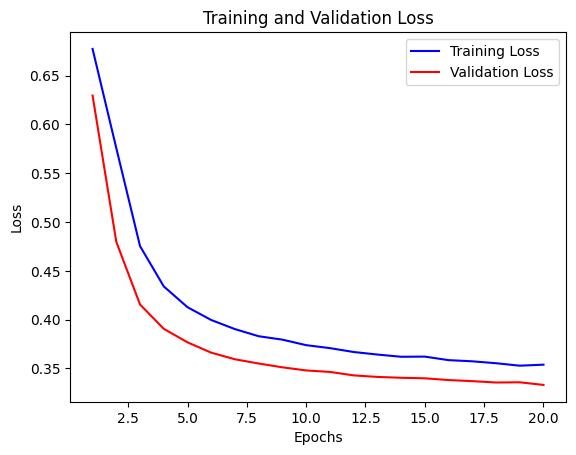

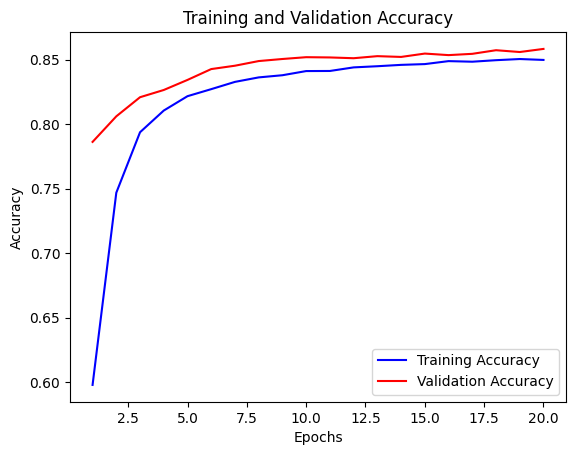

157/157 [==============================] - 0s 849us/step - loss: 0.3460 - accuracy: 0.8534


[0.34600114822387695, 0.8533999919891357]

In [17]:
# build model
w2v_model = define_model(300,)
w2v_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy'])
# train model
print("begin training")
w2v_history = w2v_model.fit(
    w2v_train_data,
    one_hot_labels,
    validation_data=(w2v_valid_data, valid_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE)
plot_training(w2v_history)
w2v_model.evaluate(w2v_test_data, test_labels)